# **Traitement de la ville d'Alep**

In [1]:
import os
import math
import numpy as np
import pandas as pd
from osgeo import gdal, osr
from tqdm.notebook import tqdm

import requests
import matplotlib.pyplot as plt
from io import BytesIO

import geopandas as gpd
from shapely import wkt

In [2]:
BASE_DIR = '..'
IMAGES_DIR = os.path.join(BASE_DIR, "data/images/alep")
DATA_DIR = os.path.join(BASE_DIR, "data/process")

In [3]:
os.makedirs(IMAGES_DIR, exist_ok=True)

Importation du fichier contenant les géolocalisations de nos données

In [4]:
df_alep = pd.read_csv(os.path.join(DATA_DIR, "data_label_alep.csv"), index_col=0)
df_alep.head(3)

,label,geometry
0,1,POINT (37.13543285100008 36.23547293500008)
1,1,POINT (37.13539414500008 36.23556617700007)
2,1,POINT (37.13908459400005 36.24100053500007)


Conversion de la colonne `geometry` au format `shapely.geometry.point.Point`  
Cette étape est nécessaire pour convertir notre DataFrame en GeoDataFrame

In [5]:
df_alep['geometry'] = df_alep['geometry'].apply(wkt.loads)
geo_alep = gpd.GeoDataFrame(df_alep, geometry = 'geometry')

**Méthodologie**: On détermine les points *lattitude max*, *lattitude min*, *longitude max*, *longitude min* pour extraire les images contenues dans ce quadrillatère.  
  
*Attention*: Le format de nos données nous donne les points sous la forme (longitude/lattitude), contrairement à Google Map qui utilise l'ordre inverse (et respecte EPSG:4326, le "Geodetic coordinate system for World")

In [6]:
liste_longitude = [coord.bounds[0] for coord in geo_alep['geometry']]
liste_lattitude = [coord.bounds[1] for coord in geo_alep['geometry']]

In [7]:
min_lon = min(liste_longitude)
max_lon = max(liste_longitude)
min_lat = min(liste_lattitude)
max_lat = max(liste_lattitude)

min_lon, max_lon, min_lat, max_lat

(37.03381997600007, 37.33491658300005, 36.13624722900005, 36.28290321700007)

On shift légèrement nos 4 points pour englober les observations correspondantes.

In [8]:
min_lon = min_lon
max_lon = max_lon
min_lat = min_lat
max_lat = max_lat

min_lon, max_lon, min_lat, max_lat

(37.03381997600007, 37.33491658300005, 36.13624722900005, 36.28290321700007)

### **Téléchargement des images**

On commence par définir au préalable tout nos paramètres utilisés

In [9]:
zoom = 19
size = 600

On choisit un niveau de zoom de 19 qui correspond à environ 0.298 metres par pixels (https://developer.tomtom.com/maps-api/maps-api-documentation/zoom-levels-and-tile-grid). Par conséquent, notre image correspond à 0.298 x 600 = 178.9 mètres environ. 

<font color="red">*On change à 0.22 pour ajuster le pas qui était légèrement trop grand*</font>

Pour l'instant en prenant les *approximations* suivantes : 
- <u>longitude</u> : 1 degré = **(40,075,000 / 360) x cos(latitude)** mètres
- <u>latitude</u> : 1 degré = **111320** mètres
  
(https://stackoverflow.com/questions/639695/how-to-convert-latitude-or-longitude-to-meters réponse de Ben)

On commence par creer les listes qui seront destinées à receuillir les coordonnées géographiques de nos images qui seront les centroïdes de chaque image.

Nous partons du points le plus bas à gauche du quadrillatère que nous avons défini précédement pour quadriller la zone (sous forme de carré)

In [10]:
(2 ** 19) * (2 ** 19)

274877906944

In [11]:
m_px = 0.274877906944

In [12]:
from math import cos

liste_lon = list()
liste_lat = list()

lat = min_lat
lon = min_lon

while lat < max_lat:
    liste_lat.append(lat)
    lat += (m_px * 600) / (111.32 * 1000)

# Attention ici on inverse les lignes (cos(.) < 0)
while lon < max_lon:
    liste_lon.append(lon)
    lon += (m_px * 600) / ((40075 * 1000) * cos(0) / 360)
    
len(liste_lon), len(liste_lat)

(204, 99)

-------------------------------------

-------------------------------------

In [13]:
def getDistanceFromLatLonInMeter(lat1, lon1, lat2, lon2):
    R = 6371 * 1000
    dLat = math.radians(lat2-lat1)
    dLon = math.radians(lon2-lon1)
    a = math.sin(dLat/2) * math.sin(dLat/2) \
            + math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) \
            * math.sin(dLon/2) * math.sin(dLon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = R * c
    return d

In [14]:
getDistanceFromLatLonInMeter(48.856667, 2.350987, 45.7673, 4.834329) # Distance Paris-Lyon

391174.7537144225

In [15]:
def reverse_haversine_test(lat1, lon1, brng, distance):
    R = 6371
    d_R = distance / R
    lat2 = math.asin(math.sin(lat1) * math.cos(d_R) \
                    + math.cos(lat1) * math.sin(d_R) * math.cos(brng)) # 90 pour aller vers l'est
    lon2 = lon1 + math.atan2(math.sin(brng) * math.sin(d_R) * math.cos(lat1),
                             math.cos(d_R) - math.sin(lat1) * math.sin(lat2))
    lon2 =  (lon2 + 540) % 360 - 180
    return lat2, lon2

In [16]:
def reverse_haversine(lat1, lon1, brng, d):
    R = 6378.1 #Radius of the Earth
    brng = 1.57 #Bearing is 90 degrees converted to radians.
    d = 15 #Distance in km

    #lat2  52.20444 - the lat result I'm hoping for
    #lon2  0.36056 - the long result I'm hoping for.

    lat1 = math.radians(52.20472) #Current lat point converted to radians
    lon1 = math.radians(0.14056) #Current long point converted to radians

    lat2 = math.asin( math.sin(lat1)*math.cos(d/R) +
         math.cos(lat1)*math.sin(d/R)*math.cos(brng))

    lon2 = lon1 + math.atan2(math.sin(brng)*math.sin(d/R)*math.cos(lat1),
                 math.cos(d/R)-math.sin(lat1)*math.sin(lat2))

    lat2 = math.degrees(lat2)
    lon2 = math.degrees(lon2)

    print(lat2)
    print(lon2)

In [17]:
reverse_haversine(10, 10, 90, 100)

52.20462299620793
0.360433887489931


In [18]:
import geopy
from geopy.distance import geodesic

# given: lat1, lon1, b = bearing in degrees, d = distance in kilometers

lat1 = 48.883709
lon1 = 2.366728
b = 45
d = 0.1

origin = geopy.Point(lat1, lon1)
destination = geodesic(kilometers=d).destination(origin, b)

lat2, lon2 = destination.latitude, destination.longitude
print(lat2, lon2)

48.884344840532044 2.3676921348950923


-------------------------------------

-------------------------------------

In [19]:
coord_images = []

for x in liste_lat:
    for y in liste_lon:
        if x < 36.16 or x > 36.26:
            pass
        elif y < 37.09 or y > 37.21:
            pass
        else:
            coord_images.append((x, y))

print("Nombre d'images candidates : {}".format(len(coord_images)))

Nombre d'images candidates : 5427


On convertie ces points en coordonnées points `shapely` pour s'assurer qu'on a bien quadrillé toute la zone.

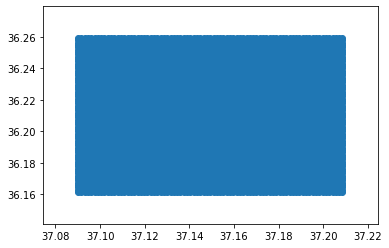

In [20]:
from shapely.geometry import Point
import matplotlib.pyplot as plt

# Attention : shapely lit les coordonnees sous la forme (longitude, lattitude)
shaply_coord = [Point(y, x) for x, y in coord_images]
plt.scatter([point.x for point in shaply_coord], [point.y for point in shaply_coord])
plt.show()

On convertie la liste `shaply_coord` en `gpd.GeoSeries` pour tenir compte des distances entre les points, ce qui n'est pas le cas quand on plot directement les coordonnées de nos points comme nous l'avons fait avec `plt.scatter`.

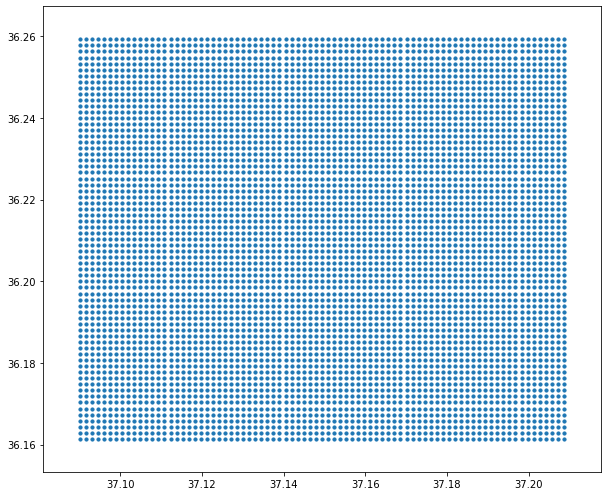

In [21]:
gpd.GeoSeries(shaply_coord).plot(figsize=(10,10), markersize=10)
plt.show()

On vient maintenant associer à chaque point les coordonnées du pixel en **bas à gauche** de l'image et du pixel en **haut à droite** pour ensuite définir le polygone carré de l'image.  
  
Cette étape est nécessaire pour ensuite être en mesure de déterminer si les coordonnées des batiments contenus dans notre base sont présents dans l'image ou non.

In [22]:
def creation_zone(point):
    """ Defini les coordonnees du point en bas a droite de l'image
        et les coordonnees du point en haut a gauche pour ensuite creer
        le polygone cree par l'image associe au point (zoom 19 seulement).
        
        Retourne un tuple de (lon, lat) dans l'ordre (bg, bd, hd, hg).
    """
    
    lat, lon = point[0], point[1]
    
    # Attention ici on inverse les lignes (cos(.) < 0)
    lon_bg = lon - (m_px * 300) / ((40075 * 1000) * cos(0) / 360)
    lon_hd = lon + (m_px * 300) / ((40075 * 1000) * cos(0) / 360)
    
    lat_bg = lat - (m_px * 300) / (111.32 * 1000)
    lat_hd = lat + (m_px * 300) / (111.32 * 1000)
    
    return ((lat_bg, lon_bg), (lat_bg, lon_hd), (lat_hd, lon_hd), (lat_hd, lon_bg))

In [23]:
zone_images = [creation_zone(point) for point in coord_images]

print("Chaque image a été traitée : {}\nNous possédons {} zones.".format(len(zone_images) == len(coord_images), len(zone_images)))
zone_images[0]

Chaque image a été traitée : True
Nous possédons 5427 zones.


((36.16069289266107, 37.0893785797742),
 (36.16069289266107, 37.09086014254151),
 (36.16217444803447, 37.09086014254151),
 (36.16217444803447, 37.0893785797742))

**Téléchargement d'une image test**

On crée une fonction sauvegardant l'image.

In [24]:
from io import BytesIO
import io
from PIL import Image
from urllib import request 
import matplotlib.pyplot as plt 
import urllib
import scipy
import imageio

In [26]:
def save_google_map(file_name, url):
    '''
    La fonction enregistre les images. 
    '''
    buffer = BytesIO(request.urlopen(url).read())
    image = imageio.imread(buffer, pilmode='RGB')
    imageio.imwrite(file_name, image)

Importation de la clé Google Map

In [42]:
cle_api_file = open(os.path.join(BASE_DIR, "data/cle_api_paul.txt"), "r")
key = cle_api_file.readline()[:-1] # supprime le caractère de fin de ligne \n

In [44]:
size_str = '600x600'
description = 'alep'

In [45]:
lat = coord_images[0][0]
lon = coord_images[0][1]
lat, lon

(36.16143367034777, 37.09011936115785)

**Attention**: [Google utilise le format *(lattitude, longitude)* dans son API](https://support.google.com/maps/answer/18539?co=GENIE.Platform%3DAndroid&hl=fr)

In [36]:
url = 'https://maps.googleapis.com/maps/api/staticmap?center=' \
        + str(lat) + ',' + str(lon) + '&zoom='+ str(19) \
        + '&size='+ size_str + '&maptype=satellite&key=' + key 

file_name = description + '_' + str(lon) + '_' + str(lat) +'.jpg'
save_google_map(file_name, url)

**Téléchargement des images satellite d'Ezzor**

Création du dossier regroupant les images satellite d'Ezzor

In [46]:
IMAGES_DIR_ALEP = os.path.join(BASE_DIR, "data/images/alep", )
os.makedirs(IMAGES_DIR_ALEP, exist_ok=True)

**Attention**: Pour Alep, il faudra construire en même temps la liste contenant le nom donné à images

In [52]:
m = 0 # compteur d'images

# ATTENTION VOIR COMMENTAIRE AU DESSUS
for coord in coord_images[4904:]:
    lat = coord[0]
    lon = coord[1]
    url = 'https://maps.googleapis.com/maps/api/staticmap?center=' \
        + str(lat) + ',' + str(lon) + '&zoom='+ str(19) \
        + '&size='+ size_str + '&maptype=satellite&key=' + key 
    file_name = description+ '_' + str(lon) + '_' + str(lat) +'.jpg'
    save_google_map(os.path.join(IMAGES_DIR_ALEP, file_name), url)
    m += 1

In [53]:
print("Nombre d'images téléchargées : {}".format(m))

Nombre d'images téléchargées : 5427


### **Associe à chaque observation l'image correspondante**

In [25]:
from shapely.geometry import Polygon

In [26]:
df_images = pd.DataFrame()

In [27]:
def image_associee(description, coord_img):
    lat = coord_img[0]
    lon = coord_img[1]
    file_name = description + '_' + str(lon) + '_' + str(lat) + '.jpg'
    return file_name

In [28]:
df_images["centroide"] = coord_images
df_images["zone"] = [tuple([(point[1], point[0]) for point in poly]) for poly in zone_images] 
df_images["image"] = df_images["centroide"].apply(lambda x: image_associee("alep", x))

# Attention : shapely lit les coordonnees sous la forme (longitude, lattitude)
df_images["centroide"] = df_images["centroide"].apply(lambda x: Point(x[1], x[0]))
df_images["zone"] = df_images["zone"].apply(lambda x: Polygon(x))

In [29]:
def is_in_image(zone, df):
    """ PREREQUIS: La df ne doit contenir que les observations
        labelisées 1.
        La fonction parcours le dataframe a la recherche d'un
        appartenant a l'image, si une image est trouvee, la
        fonction retourne 1 et s'arrete.
    """
    for point in df["geometry"]:
        if point.within(zone):
            return 1
    return 0

In [30]:
df_images["label"] = [0 for _ in range(df_images.shape[0])]
df_images["label"] = df_images["zone"].apply(lambda x: is_in_image(x, df_alep[df_alep["label"] == 1]))

nb_1 = df_images["label"].sum()
pct_1 = nb_1 / df_images["label"].shape[0]
print("Nombre d'images labelisees 1 : {0} ({1} %)".format(nb_1, round(pct_1)))

Nombre d'images labelisees 1 : 2089 (0.0 %)


In [64]:
df_images[df_images["label"]==0]

,centroide,zone,image,label
5184,POINT (37.09011936115785 36.25625321424507),"POLYGON ((36.99672349856794 36.25551243655837,...",ezzor_37.09011936115785_36.25625321424507.jpg,0


In [ ]:
# shaply_coord = [Point(y, x) for x, y in df_images['zone']]
plt.scatter([point.x for point in shaply_coord], [point.y for point in shaply_coord])
plt.show()

In [42]:
df_images = gpd.GeoDataFrame(df_images, geometry = 'zone')
df_images

,centroide,zone,image,label
0,POINT (37.09011936115785 36.16143367034777),"POLYGON ((37.08938 36.16069, 37.09086 36.16069...",alep_37.09011936115785_36.16143367034777.jpg,0
1,POINT (37.09160092392516 36.16143367034777),"POLYGON ((37.09086 36.16069, 37.09234 36.16069...",alep_37.091600923925164_36.16143367034777.jpg,0
2,POINT (37.09308248669247 36.16143367034777),"POLYGON ((37.09234 36.16069, 37.09382 36.16069...",alep_37.093082486692474_36.16143367034777.jpg,0
3,POINT (37.09456404945978 36.16143367034777),"POLYGON ((37.09382 36.16069, 37.09530 36.16069...",alep_37.094564049459784_36.16143367034777.jpg,0
4,POINT (37.09604561222709 36.16143367034777),"POLYGON ((37.09530 36.16069, 37.09679 36.16069...",alep_37.096045612227094_36.16143367034777.jpg,0
...,...,...,...,...
5422,POINT (37.20271813147342 36.25921632499186),"POLYGON ((37.20198 36.25848, 37.20346 36.25848...",alep_37.202718131473425_36.25921632499186.jpg,0
5423,POINT (37.20419969424074 36.25921632499186),"POLYGON ((37.20346 36.25848, 37.20494 36.25848...",alep_37.204199694240735_36.25921632499186.jpg,0
5424,POINT (37.20568125700805 36.25921632499186),"POLYGON ((37.20494 36.25848, 37.20642 36.25848...",alep_37.205681257008045_36.25921632499186.jpg,1
5425,POINT (37.20716281977536 36.25921632499186),"POLYGON ((37.20642 36.25848, 37.20790 36.25848...",alep_37.207162819775355_36.25921632499186.jpg,1


In [60]:
df_images['label'].mean()

0.38492721577298694

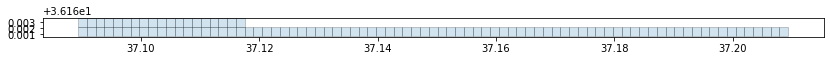

In [53]:
ax = gpd.GeoSeries(shaply_coord).plot(figsize=(14,14), markersize=10)
geo_alep.plot(column='label',legend=True,figsize=(14,14), ax=ax)
plt.show()


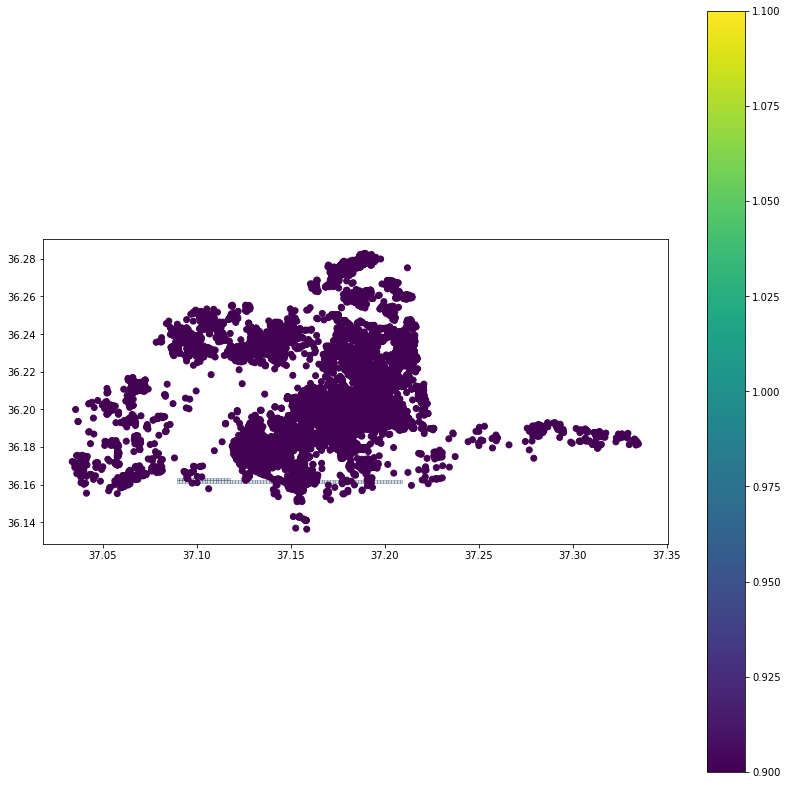

In [58]:
df_images = gpd.GeoDataFrame(df_images, geometry = 'zone')
ax = df_images['zone'][0:100].plot(figsize=(14,14), edgecolor='black', alpha=0.2)
geo_alep[geo_alep['label']==1].plot(column='label',legend=True,figsize=(14,14), ax=ax)
plt.show()

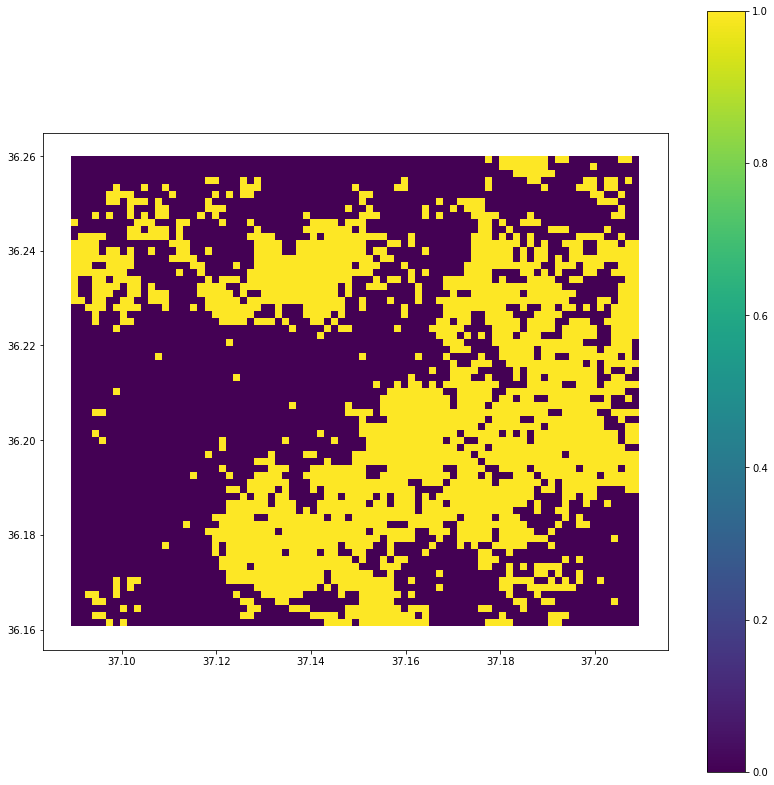

In [64]:
df_images.plot(column='label',legend=True,figsize=(14,14))
plt.show()

## **Réagencement des images pour être chargé depuis le DataLoader de PyTorch**

In [66]:
nom_images_torchvision = []
for i in range(df_images.shape[0]):
    nom_images_torchvision.append('alep_' + str(i).zfill(4) + '.jpg')
    
df_images['nom_images_torchvision'] = nom_images_torchvision

In [72]:
for i in range(df_images.shape[0]):
    ancien_nom_image = df_images.loc[i, "image"]
    nouveau_nom_image = df_images.loc[i, "nom_images_torchvision"]
    os.rename(os.path.join(IMAGES_DIR, ancien_nom_image), os.path.join(IMAGES_DIR, nouveau_nom_image))

### **Split Train - Test**

In [74]:
os.makedirs(os.path.join(IMAGES_DIR, "train"), exist_ok=True)
os.makedirs(os.path.join(IMAGES_DIR, "test"), exist_ok=True)

In [75]:
np.random.seed(42)
test_size = 0.3

segment = ["train"] * df_images.shape[0]
df_images["segment"] = segment
df_images["segment"] = df_images["segment"].apply(lambda x: "test" if np.random.random() < test_size else "train")

In [77]:
print("Taille des échantillons : train = {} / test = {}".format(df_images[df_images["segment"] == "train"].shape[0],
                                                               df_images[df_images["segment"] == "test"].shape[0]))

Taille des échantillons : train = 3778 / test = 1649


In [78]:
print("Proportion de d'images labelisées 1 : train = {} / test = {}".format(round(df_images[df_images["segment"] == "train"]["label"].mean(), 2),
                                                                            round(df_images[df_images["segment"] == "test"]["label"].mean(), 2)))

Proportion de d'images labelisées 1 : train = 0.39 / test = 0.38


In [79]:
df_images.head(3)

,centroide,zone,image,label,nom_images_torchvision,segment
0,POINT (37.09011936115785 36.16143367034777),"POLYGON ((37.08938 36.16069, 37.09086 36.16069...",alep_37.09011936115785_36.16143367034777.jpg,0,alep_0000.jpg,train
1,POINT (37.09160092392516 36.16143367034777),"POLYGON ((37.09086 36.16069, 37.09234 36.16069...",alep_37.091600923925164_36.16143367034777.jpg,0,alep_0001.jpg,train
2,POINT (37.09308248669247 36.16143367034777),"POLYGON ((37.09234 36.16069, 37.09382 36.16069...",alep_37.093082486692474_36.16143367034777.jpg,0,alep_0002.jpg,train


### **Structuration des fichiers respectant les attentes de PyTorch**

In [81]:
os.makedirs(os.path.join(IMAGES_DIR, "train", "0"), exist_ok=True)
os.makedirs(os.path.join(IMAGES_DIR, "train", "1"), exist_ok=True)
os.makedirs(os.path.join(IMAGES_DIR, "test", "0"), exist_ok=True)
os.makedirs(os.path.join(IMAGES_DIR, "test", "1"), exist_ok=True)

In [82]:
for i in range(df_images.shape[0]):
    label = df_images.loc[i, "label"]
    label = str(label)
    segment = df_images.loc[i, "segment"]
    nom_image = df_images.loc[i, "nom_images_torchvision"]
    os.replace(os.path.join(IMAGES_DIR, nom_image),
               os.path.join(IMAGES_DIR, segment, label, nom_image))

### **Sauvegarde de la base de données en .csv**

In [84]:
df_images.to_csv(os.path.join(DATA_DIR, "images_label_alep.csv"), index=False)